- Summary
- Business Understanding\
   Apple looking to understand positive and negative sentiment around their products and how to improve. Focusing on neutral 
   and negative sentiment tweets as demographics to focus on.
- Data Understanding


In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [308]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [309]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [310]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [311]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

In [312]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,@sxtxstate great stuff on fri #sxsw: marissa m...


Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [313]:
apple_related = 'ipad|apple|iphone|itunes'

In [314]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [315]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [316]:
df.dropna(subset=['tweet_text'], inplace=True)

In [317]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [318]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [319]:
apple_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              659
iPad or iPhone App                 454
iPhone                             296
Other Apple product or service      35
Android                              9
Android App                          8
Google                               7
Other Google product or service      3
Name: emotion_in_tweet_is_directed_at, dtype: int64

Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [320]:
apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [321]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
dtypes: object(2)
memory usage: 131.1+ KB


In [322]:
apple_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [323]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [324]:
custom_encoder(apple_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [325]:
apple_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [326]:
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [327]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [328]:
apple_df.duplicated().sum()

5

In [329]:
apple_df.drop_duplicates(inplace=True)

In [330]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.9+ KB


# Train Test Split

In [331]:
##apple_df = apple_df[['tweet_text', 'emotion']].copy(deep=True)

In [332]:
from sklearn.model_selection import train_test_split

X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [333]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
7403,#SXSW -Apple Pop-Up Store being set up right now on 6th St. My fellow truck driver is delivering the furniture NOW.
5609,RT @mention Check out the #dokobots game from @mention for iPhone and Android. Seems pretty cool. #geogames #SXSW #tmsxsw
8988,It's crazy here at #Apple's temporary #Austin store. Post coming up with pics. #SXSW
2394,At #SXSW conf and EVERYONE has a Mac or Ipad (including me). What happened to the PC? Is it becoming obsolete?
2461,"free #iPad Lounge open daily for #SXSW serving art made on iPads, and local art, free coffee, @mention Austin Details {link} #photo"


# Wes

C:\Users\wjsmo\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


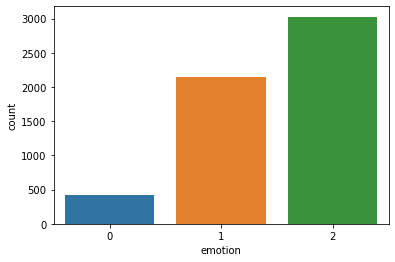

In [334]:
sns.countplot(appledf.emotion);

- Emotion is unbalanced target with much fewer negative tweets. (0 is negative, 1 is positive, 2 is neutral/can't tell)

Preprocessing

-Starting with lowercasing

In [335]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()

<ipython-input-335-8fe8f3da60a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["tweet_text"] = X_train["tweet_text"].str.lower()


In [336]:
X_train.iloc[100]['tweet_text']

"it's clear i will never be cool at #sxsw because i am without an ipad. and i'm generally not cool. doubly handicapped"

In [338]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [339]:
X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

<ipython-input-339-b8dc1dad1c62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)


In [340]:
X_train.iloc[100]["text_tokenized"][:20]

['it',
 'clear',
 'will',
 'never',
 'be',
 'cool',
 'at',
 'sxsw',
 'because',
 'am',
 'without',
 'an',
 'ipad',
 'and',
 'generally',
 'not',
 'cool',
 'doubly',
 'handicapped']

- Labeling target column (is_there_an_emotion_directed_at_a_brand_or_product) 0-2:

   -0 = Negative emotion
   -1 = Positive emotion
   -2 = No emotion AND Can't tell
   

In [344]:
from nltk import FreqDist

train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

In [345]:
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):
    
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=45)
    

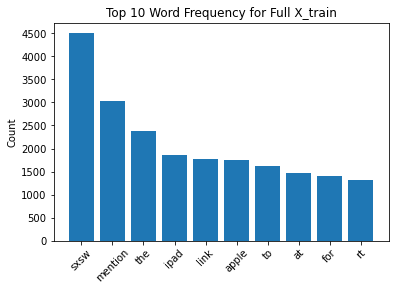

In [346]:
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

<ipython-input-349-428630240f45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["emotion"] = [y_train[val] for val in X_train.index]


IndexError: list index out of range

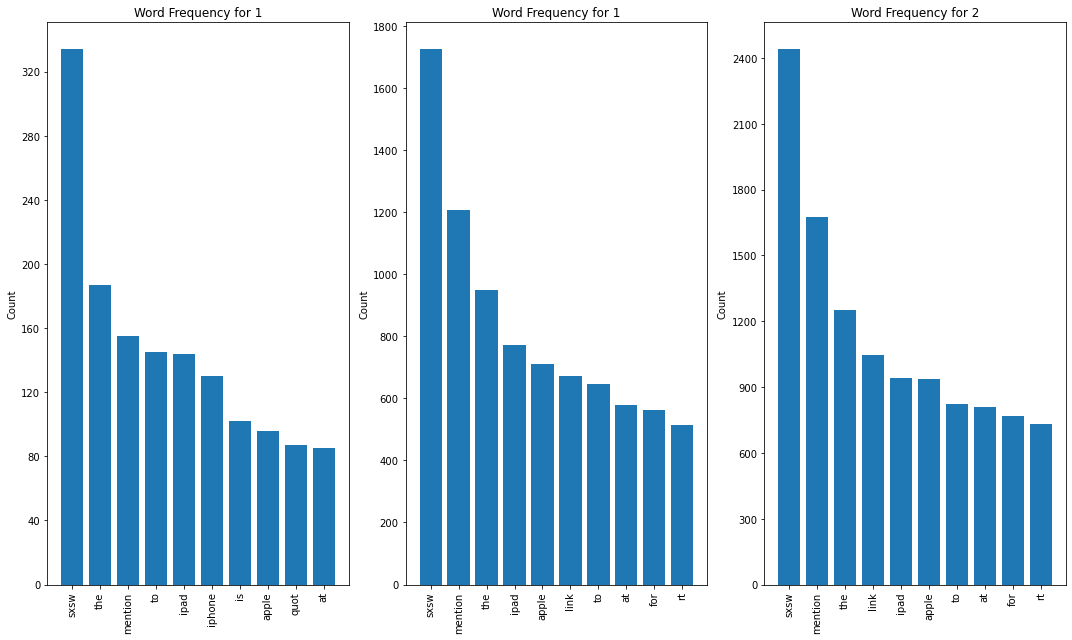

In [349]:
X_train["emotion"] = [y_train[val] for val in X_train.index]

def setup_three_subplots():
    
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 6)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    return fig, [ax1, ax2, ax3]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    for index, category in enumerate(X_train.emotion):
        # Calculate frequency distribution for this subset
        all_words = X_train[X_train["emotion"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)


fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_tokenized", axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

In [351]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,apple,at,for,ipad,link,mention,rt,sxsw,the,to
0,0.000000,0.000000,0.638839,0.000000,0.000000,0.480822,0.000000,0.289020,0.526462,0.000000
1,0.381775,0.417109,0.000000,0.719358,0.000000,0.000000,0.000000,0.194166,0.353682,0.000000
2,0.000000,0.000000,0.615714,0.516009,0.526342,0.000000,0.000000,0.278558,0.000000,0.000000
3,0.000000,0.628022,0.000000,0.000000,0.000000,0.486356,0.000000,0.292347,0.532522,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.714224,0.484153,0.214659,0.000000,0.457604
...,...,...,...,...,...,...,...,...,...,...
4185,0.472242,0.515949,0.000000,0.000000,0.000000,0.399564,0.541707,0.240177,0.000000,0.000000
4186,0.000000,0.392486,0.000000,0.000000,0.000000,0.607901,0.000000,0.182704,0.665605,0.000000
4187,0.000000,0.000000,0.000000,0.391481,0.399320,0.703161,0.000000,0.211334,0.384953,0.000000
4188,0.000000,0.000000,0.615714,0.516009,0.526342,0.000000,0.000000,0.278558,0.000000,0.000000


Double checking the shape of vectorized data. Same number of rows and 10 columns because max_features=10

In [354]:
assert X_train_vectorized.shape[0] == X_train.shape[0]
assert X_train_vectorized.shape[1] == 10

Fitting and evaluating a Multinomial Naive Bayes Classifier using cross_val_score as baseline model

In [355]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.5365155131264916

In [356]:
y_train.value_counts(normalize=True)

2    0.536516
1    0.386874
0    0.076611
Name: emotion, dtype: float64

This model appears to guess the majority class of neutral with almost exactly the same accuracy that it appears. 

# Namsoo

# Harshitha

## EDA